In [6]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [7]:
env = BlackjackEnv()

In [8]:
print(env.reset())

(12, 4, False)


In [9]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """

    def policy_fn(observation):
        A = np.zeros(nA)
        # Explore randomly if episilon probability is selcted
        if np.random.random() > epsilon: # take the most optimal action
            action = np.argmax(Q[observation])
            A[action] = 1
        else: # take some random action
            prob_to_stick = np.random.randint(0, nA)
            A[0] = prob_to_stick
            A[1] = (1 - prob_to_stick)

        return A
        

    return policy_fn

In [12]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(1, num_episodes + 1):
        # show an visual update for which episode we are on
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # initialize the episode object and the starting state
        episode = []
        state = env.reset()
        # iterate through each step in the episode, until we reach the end of the episode
        while True:
            action_probs = policy(state)
            # choose the action chosen based on the given probabilities (Monte Carlo applied here)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            # get the environmental information about this action
            next_state, reward, done, _ = env.step(action)
            # update episode tuple
            episode.append((state, action, reward))
            # stopping condition
            if done: break
            state = next_state
        
        # Once our episode has terminated we need to calculate the G value and update the action-value function and our policy
        # NOTE we are again using first-occurence MC because BlackJack doesn't ever repeat states during an episode
        # because even in the case of reaching the same value with an ace, now the ace_present flag is activated
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            first_sa_idx = next(i for i, x in enumerate(episode) if x[0] == state and x[1] == action)
            # sum all the rewards since the first occurrence 
            G = sum([x[2] * (discount_factor**i) for i, x in enumerate(episode[first_sa_idx:])])
            # calculate the returns_sum and returns_count
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1
            # calculate the observed mean return 
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]

        # NOTE the policy is improving implicitly by changing the Q dictionary

    return Q, policy

In [13]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 500000/500000.

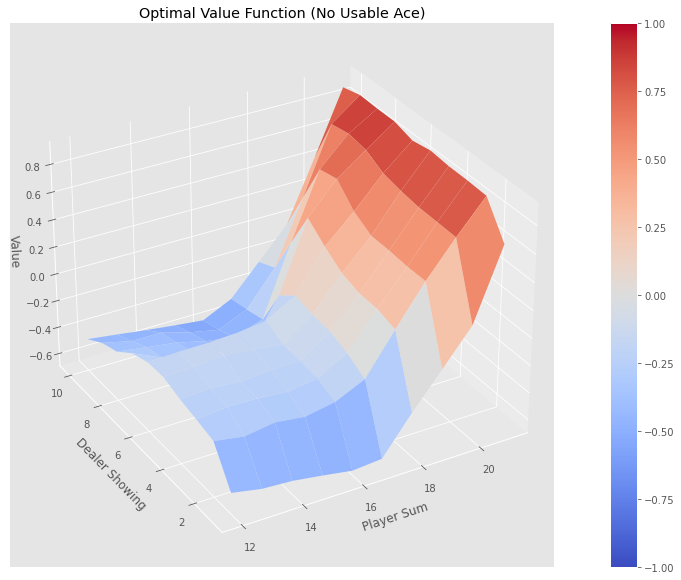

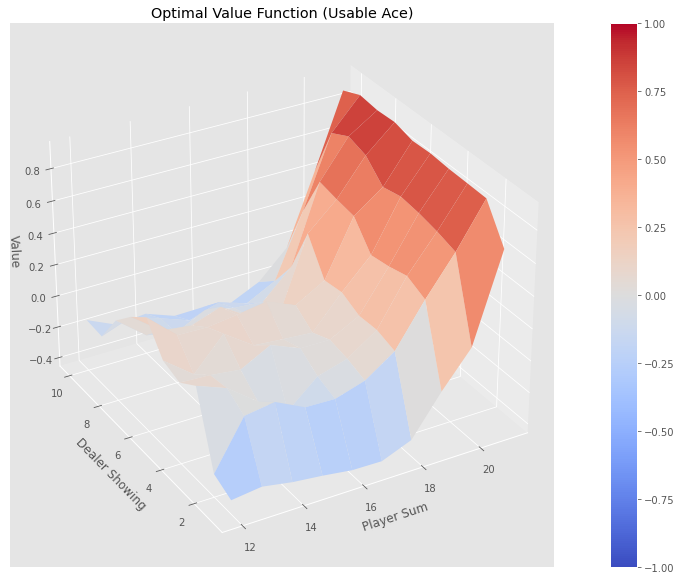

In [14]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")